In [1]:
from dms2dec.dms_convert import dms2dec
import math
import pandas as pd
import sklearn.metrics as metrics

In [2]:
# provide function with two touples of latitude and longitude
# example: distanceFromLatLon((lat1, lon1), (lat2, lon2))
def distanceFromLatLon(latlon1, latlon2):
    lat1, lon1 = latlon1
    lat2, lon2 = latlon2
    R = 6371#Radius of Earth in km
    dLat = math.radians(lat2-lat1)
    dLon = math.radians(lon2-lon1)
    a = \
        math.sin(dLat/2) * math.sin(dLat/2) + \
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * \
        math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

In [3]:
id_dict = {
            'v220556': 47,
            'v220558': 49,
            'v220561': 50,
            'v220566': 54,
            'v44783': 93,
            'v44784': 94,
            'v44786': 96,
            'v44787': 97,
          }
headers = ["Latitude", "Longitude", "Id", "Title"]
df = pd.read_csv('../AssetsData/asset_cleaned_data.csv', names=headers, sep=';', skiprows=1)
df.drop(columns=['Title'], inplace=True, axis=1)
df['Latitude'] = [dms2dec(x) for x in df['Latitude']]
df['Longitude'] = [dms2dec(x) for x in df['Longitude']]
#df = df.filter(items=id_dict.keys())
df = df[df['Id'].isin(id_dict.keys())]
df.reset_index(drop=True, inplace=True)
df.reset_index(inplace=True)
df['Id'].replace(to_replace=id_dict, inplace=True)
print(len(df))
df.head()

8


index   Latitude  Longitude  Id
0      0  56.703569   9.768325  93
1      1  56.701050   9.770086  94
2      2  56.696075   9.767061  96
3      3  56.694644   9.762917  97
4      4  55.855608   8.428783  47

In [4]:
ids = [int(x[3]) for x in df.values]
mat = []
for i in range(len(ids)):
    mat.append([0.0] * len(ids))

for i in df.values:
    for j in df.values:
        if i[0] == j[0]:
            mat[int(i[0])][int(j[0])] = float('inf')
        else:
            latlon1 = (i[1], i[2])
            latlon2 = (j[1], j[2])
            mat[int(i[0])][int(j[0])] = distanceFromLatLon(latlon1, latlon2)
print(mat)
print(ids)

[[inf, 0.3000689856601346, 0.8369086328434329, 1.045899127172769, 125.40571320761191, 125.39654533271464, 126.22950464584902, 126.20234912311115], [0.3000689856601346, inf, 0.5832072933546606, 0.8360090929433284, 125.26885190097158, 125.25819404331435, 126.09441025640416, 126.06352201365763], [0.8369086328434329, 0.5832072933546606, inf, 0.2988887021176524, 124.73410838272127, 124.72215484290037, 125.561217003148, 125.52706889092384], [1.045899127172769, 0.8360090929433284, 0.2988887021176524, inf, 124.44655460179368, 124.43506388458866, 125.27312917957222, 125.24012931308283], [125.40571320761191, 125.26885190097158, 124.73410838272127, 124.44655460179368, inf, 0.7003375273936543, 1.170452850887442, 1.2218535026139774], [125.39654533271464, 125.25819404331435, 124.72215484290037, 124.43506388458866, 0.7003375273936543, inf, 1.7455567767520164, 0.8363352318501025], [126.22950464584902, 126.09441025640416, 125.561217003148, 125.27312917957222, 1.170452850887442, 1.7455567767520164, inf,

In [5]:
def getNearestNeighbors(assetId):  
    nn_df = pd.DataFrame(columns=['id', 'neighbor1', 'neighbor2', 'neighbor3'])
    for i, line in enumerate(mat):
        new_line = sorted(line)
        new_df = pd.DataFrame({
            'id': ids[i],
            'neighbor1': ids[mat[i].index(new_line[0])],
            'neighbor2': ids[mat[i].index(new_line[1])],
            'neighbor3': ids[mat[i].index(new_line[2])],
        },index=[0])
        nn_df = pd.concat([nn_df, new_df])

    nn_df.reset_index(drop=True, inplace=True)
    return nn_df[nn_df['id'] == assetId]

#print(getNearestNeighbours(93))
    
#nn_df.head(8)

Trying to combine the models


In [7]:
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'active_power_watt' in the data file
parse_dates = ['time_utc']
df = pd.read_csv('../online_data/formatted_data_march.csv', sep=',', parse_dates=parse_dates, dtype=np.float64)
assetId = int(input("Choose an asset id to train on: "))
tpot_data = df[df['id'] == assetId]

tpot_data = tpot_data[['time_utc', 'wind_speed_ms', 'wind_direction_degrees', 'temperature', 'active_power_watt']]

tpot_data = tpot_data[tpot_data['active_power_watt'] >= 0]

day = int(input('Which day of March?: '))
cond1 = (tpot_data.time_utc < pd.Timestamp(2022,3,day,0,0)) | (tpot_data.time_utc > pd.Timestamp(2022,3,day+1,0,0))
tpot_data = tpot_data.loc[cond1]

train, test = train_test_split(tpot_data, test_size = 0.2)
test = test[['wind_speed_ms', 'wind_direction_degrees', 'temperature', 'active_power_watt', 'time_utc']]

features = train.drop(['active_power_watt', 'time_utc'], axis=1)

training_features, testing_features, training_target, testing_target = \
            train_test_split(features, train['active_power_watt'], random_state=1)

# Average CV score on the training set was: 0.8821633815645982
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=RidgeCV()),
    GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="huber", max_depth=3, max_features=1.0, min_samples_leaf=12, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 1)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

c:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(


In [8]:
parse_dates = ['time_utc']
print(test.shape)

test = test[test['active_power_watt'] > 0]
print(test.shape)


results = exported_pipeline.predict(test.drop(['active_power_watt', 'time_utc'], axis = 1, inplace = False))

y_predicted = []
accuracies = []
i = 0
for index, row in test.iterrows():
    if row[3] != 0:
        accuracies.append(100 - abs(((row[3] - results[i]) / row[3]) * 100))
    y_predicted.append(results[i])    
    i += 1
   
     
print(metrics.r2_score(test['active_power_watt'].values, y_predicted))
print(f'Accuracy: {np.mean(accuracies)} %')

(15170, 5)
(15141, 5)


c:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(


0.928890182496407
Accuracy: -179.14781798776824 %


In [9]:
import matplotlib.pyplot as plt
#ax1 = sns.distplot(test['active_power_watt'], hist = False, color = 'r', label='Actual Value')

#sns.distplot(results, hist=False, color = 'b', label = 'Fitted Values', ax = ax1).set(title='MLR')¨
#plt.figure(figsize = (80,30))
#plt.plot(test['time_utc'], results)
#plt.plot(test['time_utc'], test['active_power_watt'])

#plt.show()

In [10]:
#lets pretend that id 93 has a fallout
neighbors = getNearestNeighbors(assetId)

n_df = df.loc[df['id'].isin(neighbors['neighbor1'])]
n_df = n_df.append(df.loc[df['id'].isin(neighbors['neighbor2'])])
n_df = n_df.append(df.loc[df['id'].isin(neighbors['neighbor3'])])

#round the time to 30 s and remove duplicates
n_df = n_df.set_index('time_utc')
n_df = n_df.sort_index()
n_df.index = n_df.index.round('30s')

df = df.set_index('time_utc')
df = df.sort_index()
df.index = df.index.round('30s')

subset = n_df.sort_values(by = 'time_utc')
subset[subset.index.duplicated()]
subset = subset[~subset.index.duplicated()]

print(df.shape)
subset = df.sort_values(by = 'time_utc')
subset[subset.index.duplicated()]
subset = subset[~subset.index.duplicated()]
print(df.shape)

C:\Users\User\AppData\Local\Temp\ipykernel_18372\922302451.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_df = n_df.append(df.loc[df['id'].isin(neighbors['neighbor2'])])
C:\Users\User\AppData\Local\Temp\ipykernel_18372\922302451.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_df = n_df.append(df.loc[df['id'].isin(neighbors['neighbor3'])])


(538271, 5)
(538271, 5)


In [11]:
def get_prediction(wind_speed, wind_direction, temperature):
    #suppose that the regression model has already been created and trained for the specific asset id
    mean_df = pd.DataFrame({'wind_speed_ms': [wind_speed], 'wind_direction_degrees': [wind_direction], 'temperature': [temperature]})
    result = exported_pipeline.predict(mean_df)
    return result

In [12]:
def get_mismatch_for_time(id, time, n_df):
    n_df = n_df[n_df.index == time]
    df_id = df.loc[(df.id.isin([id])) & (df.index == time)]
    #print(len(n_df))
    if len(n_df) >= 1 and len(df_id) > 0:
        wind_speed = n_df['wind_speed_ms'].mean()
        wind_direction = n_df['wind_direction_degrees'].mean()
        temperature = n_df['temperature'].mean()

        prediction = get_prediction(wind_speed, wind_direction, temperature)
        actual_value = df_id.iloc[0]['active_power_watt']
        
        return (((abs(actual_value - prediction[0])/((actual_value + prediction[0]) / 2))) * 100)

In [13]:
import warnings
warnings.filterwarnings("ignore")
times = [x for x in df.index.values if x > pd.Timestamp(2022,3,9,12,0) and x < pd.Timestamp(2022,3,10,0,0)]
times = sorted(times)

"""

y_predicted = []
actual_values = []
wind_speed_mean = []
for time in times:
    n_df1 = n_df[n_df.index == time]
    df_id = df.loc[(df.id.isin([assetId])) & (df.index == time)]
    if len(n_df1) >= 2 and len(df_id) > 0:
        wind_speed = n_df1['wind_speed_ms'].mean()
        wind_direction = n_df1['wind_direction_degrees'].mean()
        temperature = n_df1['temperature'].mean()
        wind_speed_mean.append(wind_speed * 1000000)
        y_predicted.append(get_prediction(wind_speed, wind_direction, temperature))
        actual_values.append(df_id.iloc[0]['active_power_watt'])

#print(f'mismatch length: {len(mismatches)}')
#print(f'Average mismatch: {np.mean(mismatches)} %')
print(f'r2: {metrics.r2_score(actual_values, y_predicted)}')

#ax1 = sns.distplot(test['active_power_watt'], hist = False, color = 'r', label='Actual Value')
#sns.distplot(results, hist=False, color = 'b', label = 'Fitted Values', ax = ax1).set(title='MLR')
#sns.distplot(wind_speed_mean, hist=False, color = 'g')
from matplotlib.pyplot import figure
figure(figsize=(16, 12))

plt.plot(times, y_predicted, color="blue")
plt.plot(times, actual_values, color="red")
plt.plot(times, wind_speed_mean, color="green")
plt.show()
"""

'\n\ny_predicted = []\nactual_values = []\nwind_speed_mean = []\nfor time in times:\n    n_df1 = n_df[n_df.index == time]\n    df_id = df.loc[(df.id.isin([assetId])) & (df.index == time)]\n    if len(n_df1) >= 2 and len(df_id) > 0:\n        wind_speed = n_df1[\'wind_speed_ms\'].mean()\n        wind_direction = n_df1[\'wind_direction_degrees\'].mean()\n        temperature = n_df1[\'temperature\'].mean()\n        wind_speed_mean.append(wind_speed * 1000000)\n        y_predicted.append(get_prediction(wind_speed, wind_direction, temperature))\n        actual_values.append(df_id.iloc[0][\'active_power_watt\'])\n\n#print(f\'mismatch length: {len(mismatches)}\')\n#print(f\'Average mismatch: {np.mean(mismatches)} %\')\nprint(f\'r2: {metrics.r2_score(actual_values, y_predicted)}\')\n\n#ax1 = sns.distplot(test[\'active_power_watt\'], hist = False, color = \'r\', label=\'Actual Value\')\n#sns.distplot(results, hist=False, color = \'b\', label = \'Fitted Values\', ax = ax1).set(title=\'MLR\')\n#sn

In [14]:
def import_data(file_name, headers):
    # import
    data = pd.read_csv(f'../online_data/{file_name}.csv', sep=',', parse_dates=['time_utc']) 
    df = pd.DataFrame(data)
    df = df[df['active_power_watt'] > 0]

    # set titles
    df.columns = headers

    # round the time to 30 seconds
    df['time_utc'] = df['time_utc'].round('30s')
    return df

In [15]:
from sklearn import ensemble

df = pd.read_csv('../AssetsData/formatted_data_march.csv', sep=',', parse_dates=parse_dates, dtype=np.float64)
df['time_utc'] = df['time_utc'].round('30s')
df = df[df['active_power_watt'] > 0]
assetId = 47
asset_train_data = df[df['id'] == assetId]

cond1 = (asset_train_data.time_utc < pd.Timestamp(2022,3,9,0,0)) | (asset_train_data.time_utc > pd.Timestamp(2022,3,27,0,0))
asset_train_data = asset_train_data.loc[cond1]

training_features = asset_train_data[['wind_speed_ms', 'wind_direction_degrees', 'temperature']]
training_target = asset_train_data[['active_power_watt']]
regressor = ensemble.GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="huber", max_depth=3, max_features=1.0, min_samples_leaf=12, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001)
regressor.fit(training_features, training_target)

: 

: 

In [49]:
import warnings
warnings.filterwarnings("ignore")
times = [x for x in df.time_utc if x > pd.Timestamp(2022,3,9,9,0) and x < pd.Timestamp(2022,3,9,12,0)]
times = sorted(times)

wind_speed_mean = []
actual_values = []
y_predicted = []

for time in times:
    n_df1 = n_df[n_df.index == time]
    df_id = df.loc[(df.id.isin([assetId])) & (df.time_utc == time)]
    if len(n_df1) >= 2 and len(df_id) > 0:
        wind_speed = n_df1['wind_speed_ms'].mean()
        wind_direction = n_df1['wind_direction_degrees'].mean()
        temperature = n_df1['temperature'].mean()
        wind_speed_mean.append(wind_speed * 1000000)

        mean_df = pd.DataFrame({'wind_speed_ms': [wind_speed], 'wind_direction_degrees': [wind_direction], 'temperature': [temperature]})
        result = exported_pipeline.predict(mean_df)
        y_predicted.append(result)
        
        actual_values.append(df_id.iloc[0]['active_power_watt'])

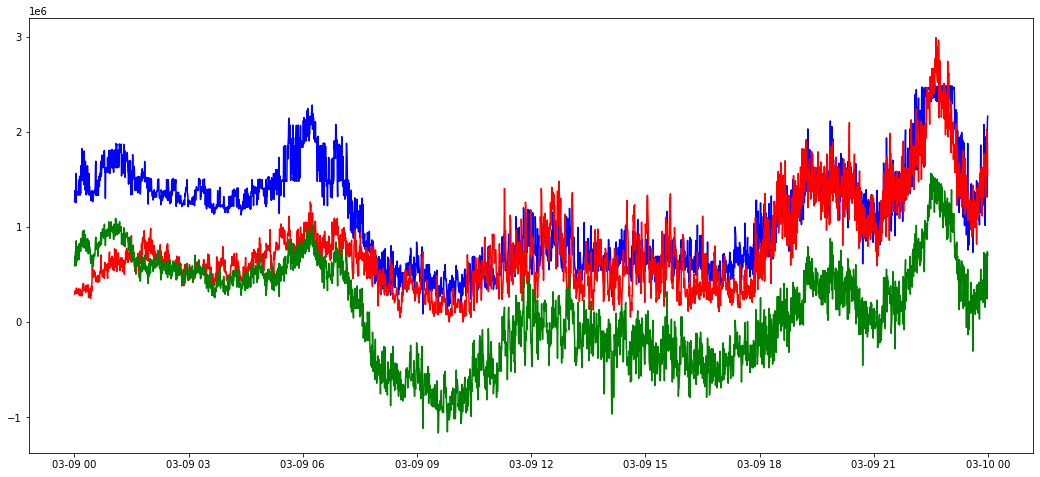

In [50]:
from matplotlib.pyplot import figure
figure(figsize=(18, 8))

plt.plot(times, y_predicted, color="blue")
plt.plot(times, actual_values, color="red")
plt.plot(times, wind_speed_mean, color="green")
plt.show()